# Time Series Decomposition

This chapter is about breaking down a time series into its consitutient components

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
data =  pd.read_csv("kaggle_data\DailyDelhiClimateTrain.csv")
data["date"] = pd.to_datetime(data["date"])


## Log transformation of data

C:\Users\alber\anaconda3\envs\forecast\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\alber\anaconda3\envs\forecast\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='date'>

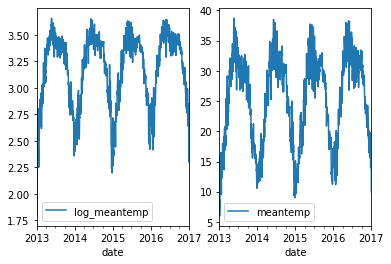

In [29]:
data["log_meantemp"] = data["meantemp"].apply(lambda x: math.log(x))

fig,ax = plt.subplots(1,2)

data.plot(x = "date", y = "meantemp",ax = ax[1])
data.plot(x = "date", y = "log_meantemp",ax = ax[0])

# really no difference between the two subplots being made

# Moving Averages

Given that data is daily counts, run a 30 day rolling average to capture monthly means

In [35]:
data["meantemp_30ma"] =  data["meantemp"].rolling(30).mean()

<AxesSubplot:xlabel='date'>

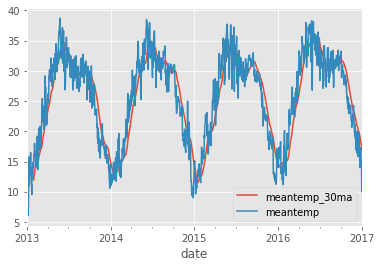

In [39]:
plt.style.use("ggplot")

data.plot(x = "date", y = ["meantemp_30ma","meantemp"])
# notice how the 30 day MA captures the trend without all cylic effects

## Classical Decomposition

Classical decompostion has two forms ( additive and multiplicative ).  
We will be doing additive.

Steps are:
1. Compute trend cycle component
2. Calculate detrended series
3. Average detrended values across season for seasonal component
4. Remainder is the difference between time series and these two components

<AxesSubplot:xlabel='date'>

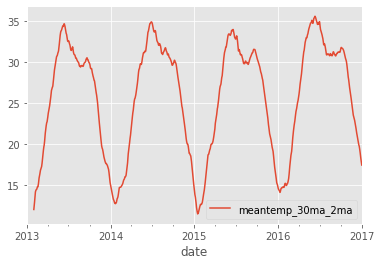

In [41]:
# Compute trend cycle with a 2 x 30 - MA. Daily data with a monthly pattern

data["meantemp_30ma_2ma"] = data["meantemp_30ma"].rolling(2).mean()

data.plot(x = "date", y = ["meantemp_30ma_2ma"])

,date,meantemp,humidity,wind_speed,meanpressure,log_meantemp,meantemp_12ma,meantemp_30ma,meantemp_30ma_2ma,detrended_meantemp
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2.302585,"Rolling [window=12,center=False,axis=0]",NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2.001480,"Rolling [window=12,center=False,axis=0]",NaN,NaN,NaN
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1.969441,"Rolling [window=12,center=False,axis=0]",NaN,NaN,NaN
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2.159484,"Rolling [window=12,center=False,axis=0]",NaN,NaN,NaN
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1.791759,"Rolling [window=12,center=False,axis=0]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2.845920,"Rolling [window=12,center=False,axis=0]",18.164807,18.252093,-1.034702
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2.723799,"Rolling [window=12,center=False,axis=0]",17.952373,18.058590,-2.820495
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2.645837,"Rolling [window=12,center=False,axis=0]",17.759896,17.856134,-3.760896
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2.711553,"Rolling [window=12,center=False,axis=0]",17.603317,17.681606,-2.628975


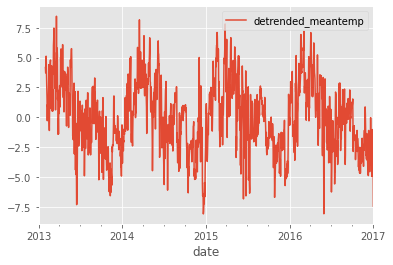

In [44]:
# Compute the detrended series
data["detrended_meantemp"] = data["meantemp"] - data["meantemp_30ma_2ma"]

data.plot(x = "date", y = ["detrended_meantemp"])

<AxesSubplot:xlabel='date'>

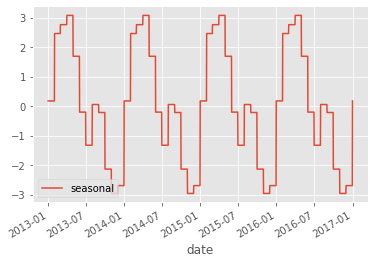

In [66]:
# Compute the seasonal component by averaging each specific month across the years
data["month"] =  data["date"].dt.month

seasonal = pd.DataFrame(data.groupby("month")["detrended_meantemp"].mean())
seasonal.rename(columns = {"detrended_meantemp":"seasonal"},inplace = True)

data =  pd.merge(data,seasonal, on = "month")
data.plot(x = "date",y="seasonal")




<AxesSubplot:xlabel='date'>

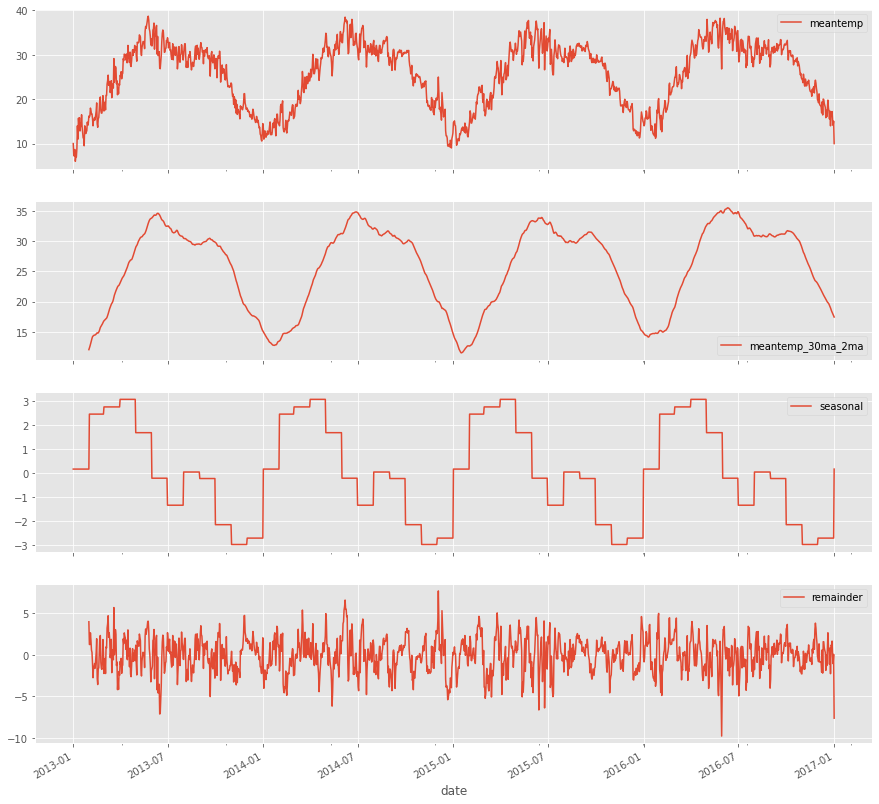

In [78]:
# Compute the remainder as the difference between time series and these two components

data["remainder"] = data["meantemp"] - data["seasonal"] - data["meantemp_30ma_2ma"]
data

fig,ax = plt.subplots(4,1,figsize = (15,15), sharex= True)

data.plot(x = "date", y = "meantemp", ax = ax[0])
data.plot(x = "date", y = "meantemp_30ma_2ma", ax = ax[1])
data.plot(x = "date", y = "seasonal", ax = ax[2])
data.plot(x = "date", y = "remainder", ax = ax[3])

## STL Decomposition

Classical decomposition is quite annoying to implement, and performs poorly

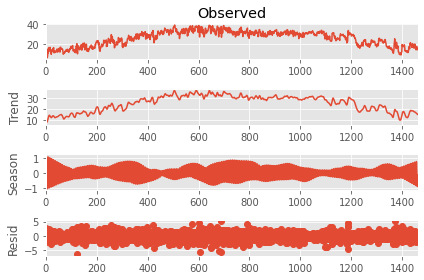

In [90]:
from statsmodels.tsa.seasonal import STL

# data = data.loc[:,"meantemp"]
data = pd.DataFrame(data)

stl = STL(data, seasonal=31,period = 7)
res = stl.fit()
fig = res.plot()

# much easier to implement, however defintely should revise theory to see what the optimal seasonal and period numbers are